In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio
import subprocess
from rasterstats import zonal_stats
from sodapy import Socrata
from shapely.geometry import shape
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings

pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

In [2]:
#getting the noise data
data_dir = "data/CONUS_rail_road_and_aviation_noise_2020/State_rasters/"
search_pattern = os.path.join(data_dir, "*_rail_road_and_aviation_noise_2020.tif")
output_vrt = os.path.join(data_dir, "CONUS_merged_noise_map_2020.vrt")

tif_files = glob.glob(search_pattern)

if not tif_files:
    print(f"--- ERROR ---")
    print(f"No .tif files were found at: {search_pattern}")
else:
    print(f"Found {len(tif_files)} state raster files to link.")
    
    command_list = ["gdalbuildvrt", output_vrt] + tif_files
    
    print("Building VRT file...")
    
    try:
        subprocess.run(command_list, check=True, shell=True)
        
        print(f"\n--- Success! ---")
        print(f"Virtual Raster .vrt file created at:")
        print(output_vrt)
        
    except subprocess.CalledProcessError as e:
        print(f"\n--- GDAL ERROR ---")
        print(f"The command failed: {e}")
        print("Please ensure GDAL is installed in your active Conda environment.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

Found 49 state raster files to link.
Building VRT file...

--- Success! ---
Virtual Raster .vrt file created at:
data/CONUS_rail_road_and_aviation_noise_2020/State_rasters/CONUS_merged_noise_map_2020.vrt


In [3]:
data_dir = "data/CONUS_rail_road_and_aviation_noise_2020/State_rasters/"
NOISE_RASTER_PATH = os.path.join(data_dir, "CONUS_merged_noise_map_2020.vrt")
CDC_APP_TOKEN = "ReEZWmd3hqYSQ879UCZyhtP1T" 

In [4]:
# --- HELPER CLASS ---
class DataPipeline:
    """
    Handles data ingestion and geometry processing for CDC and Census data.
    """
    def __init__(self, cdc_token, noise_path):
        self.cdc_token = cdc_token
        self.noise_path = noise_path
        self.NE_STATES = ['PA', 'NJ', 'NY', 'CT', 'RI', 'MA', 'NH', 'VT', 'ME']

    def get_cdc_data(self, limit=50000):
        """Fetches and cleans CDC PLACES data."""
        print(f"Fetching {limit} records from CDC API...")
        client = Socrata("data.cdc.gov", self.cdc_token)
        dataset_id = "swc5-untb"
        results = client.get(dataset_id, limit=limit)
        
        gdf = gpd.GeoDataFrame.from_records(results)
        
        # Geometry processing
        gdf = gdf.dropna(subset=['geolocation'])
        gdf['geometry'] = gdf['geolocation'].apply(lambda x: shape(x))
        gdf = gdf.set_geometry('geometry', crs="EPSG:4326")
        
        # Filter for NE States
        gdf = gdf[gdf['stateabbr'].isin(self.NE_STATES)]
        
        # Numeric conversion
        gdf['data_value'] = pd.to_numeric(gdf['data_value'], errors='coerce')
        return gdf

    def get_counties(self):
        """Fetches US County boundaries."""
        print("Downloading County Boundaries...")
        url = "https://www2.census.gov/geo/tiger/TIGER2022/COUNTY/tl_2022_us_county.zip"
        counties = gpd.read_file(url)
        counties = counties.to_crs("EPSG:4326")
        
        # Create FIPS
        counties['FIPS'] = counties['STATEFP'] + counties['COUNTYFP']
        return counties[['FIPS', 'geometry']]

# --- UTILITY FUNCTIONS ---
def calculate_vif(df):
    """Calculates Variance Inflation Factor to check for multicollinearity."""
    # Handle infinite/nan values just in case
    df = df.replace([np.inf, -np.inf], np.nan).dropna()
    vif_data = pd.DataFrame()
    vif_data["feature"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(len(df.columns))]
    return vif_data.sort_values('VIF', ascending=False)

def plot_correlation_matrix(df, title="Correlation Matrix"):
    """Plots a publication-quality heatmap."""
    plt.figure(figsize=(10, 8))
    corr = df.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    sns.heatmap(corr, mask=mask, cmap='RdBu_r', center=0, square=True, linewidths=.5)
    plt.title(title, fontsize=14)
    plt.tight_layout()
    plt.show()

# Initialize Pipeline
pipeline = DataPipeline(CDC_APP_TOKEN, NOISE_RASTER_PATH)

In [5]:
# 1. Load Data
cdc_gdf = pipeline.get_cdc_data(limit=250000)
counties_gdf = pipeline.get_counties()

# 2. Pivot CDC Data (Wide Format)
print("Pivoting CDC data...")
health_pivot = cdc_gdf.pivot_table(
    index=['locationid', 'locationname', 'stateabbr'],
    columns='measure',
    values='data_value',
    aggfunc='mean'
).reset_index()

Fetching 250000 records from CDC API...
Pivoting CDC data...


In [6]:
# 3. Merge with Geometries
model_gdf = counties_gdf.merge(health_pivot, left_on='FIPS', right_on='locationid', how='inner')

In [7]:
model_gdf = model_gdf.set_geometry('geometry')

print(f"Final Dataset: {len(model_gdf)} counties ready for analysis.")

Final Dataset: 218 counties ready for analysis.


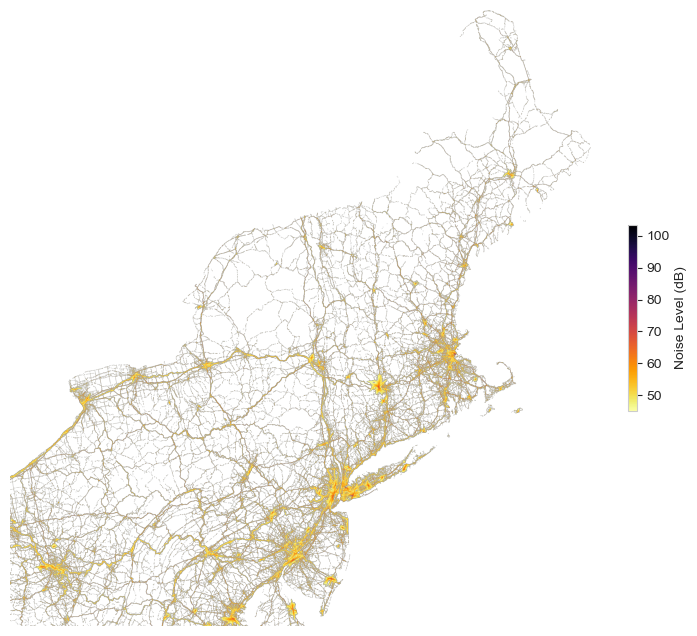

In [8]:
import rasterio
from rasterio.mask import mask
from rasterio.plot import show
from rasterio.windows import from_bounds
from rasterio.enums import Resampling
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import mapping
import numpy as np

DOWNSAMPLE_FACTOR = 0.1

with rasterio.open(NOISE_RASTER_PATH) as src:
        model_gdf = model_gdf.to_crs(src.crs)
        minx, miny, maxx, maxy = model_gdf.total_bounds
        window = from_bounds(minx, miny, maxx, maxy, src.transform)
        new_height = int(window.height * DOWNSAMPLE_FACTOR)
        new_width = int(window.width * DOWNSAMPLE_FACTOR)
        out_image = src.read(
        1,
        window=window,
        out_shape=(new_height, new_width),
        resampling=Resampling.bilinear
    )

noise_data_masked = np.ma.masked_less_equal(out_image, 0)

fig, ax = plt.subplots(figsize=(12, 8))

img = ax.imshow(
    noise_data_masked, 
    cmap='inferno_r', 
    extent=(minx, maxx, miny, maxy),
    origin='upper'
)

# Formatting
plt.colorbar(img, ax=ax, label="Noise Level (dB)", fraction=0.01, pad=0.04)
plt.xlabel("Longitude")
plt.ylabel("Latitude")

ax.set_axis_off()
fig.patch.set_facecolor('none')
ax.patch.set_facecolor('none')
plt.tight_layout
plt.show()

In [9]:
# 1. Calculate Naive Zonal Statistics (Arithmetic Mean)
# Note: This is physically incorrect for decibels, but demonstrated for baseline comparison.
with rasterio.open(NOISE_RASTER_PATH) as src:
    target_crs = src.crs
    nodata_val = src.nodata

model_gdf = model_gdf.to_crs(target_crs)

stats_arithmetic = zonal_stats(
    model_gdf,
    NOISE_RASTER_PATH,
    stats=['mean'],
    all_touched=True,
    band=1,
    nodata=nodata_val
)

result_gdf = pd.DataFrame(stats_arithmetic)
result_gdf['locationid'] = model_gdf['locationid'].values
result_gdf = result_gdf.rename(columns={'mean': 'avg_noise_db'})
result_gdf = result_gdf.dropna(subset=['avg_noise_db'])

## I calculated arithmetic mean for decibel value which is physically incorrect due to dB being logarithmic. By using arithmetic mean, this significantly underestimates total noise exposure. While it would be more accurate to convert the raster to acoustic energy, do the zonal stats on energy, then convert back to dB, my abilities and laptop are far too limited to do this. Making this a limitation of my analysis. 

In [10]:
model_gdf = model_gdf.merge(
    result_gdf,
    on='locationid',
    how='left'
)

In [11]:
# 1. DEFINE CENSUS FETCHING FUNCTION
# ---------------------------------------------------------
def fetch_census_data_standalone():
    """
    Fetches 2023 ACS 5-Year Data via US Census API for Northeast States.
    Returns a cleaned DataFrame ready for merging.
    """
    print("Fetching US Census ACS Data (Income, Poverty, Race, Education)...")
    
    # NE State FIPS: CT, ME, MA, NH, NJ, NY, PA, RI, VT
    ne_fips = ["09", "23", "25", "33", "34", "36", "42", "44", "50"]
    
    # Map API variables to readable names
    vars_map = {
        "B01003_001E": "Total_Pop",
        "B19013_001E": "Median_Income",
        "B17001_002E": "Poverty_Count",
        "B03002_003E": "White_Count",
        "B03002_004E": "Black_Count",
        "B03002_006E": "Asian_Count",
        "B03002_012E": "Hispanic_Count",
        "B15003_022E": "Bachelor_Degree_Count",
        "B09020_001E": "Senior_Count"
    }
    
    var_string = ",".join(vars_map.keys())
    dfs = []
    
  
    for fips in ne_fips:
        url = f"https://api.census.gov/data/2023/acs/acs5?get=NAME,{var_string}&for=county:*&in=state:{fips}"
        try:
            df = pd.read_json(url)
            df.columns = df.iloc[0]
            df = df[1:]
            dfs.append(df)
        except Exception as e:
                print(f"Error fetching state {fips}: {e}")
        
    if not dfs:
         raise ValueError("Failed to fetch Census data.")
    
    census = pd.concat(dfs, ignore_index=True)
    
    # Create 5-digit FIPS for merging (State + County)
    census['FIPS'] = census['state'] + census['county']
    
    # Rename columns
    census = census.rename(columns=vars_map)
    
    # Convert to Numeric
    for col in vars_map.values():
        census[col] = pd.to_numeric(census[col], errors='coerce')
        
    census['Pct_Poverty'] = (census['Poverty_Count'] / census['Total_Pop']) * 100
    census['Pct_White'] = (census['White_Count'] / census['Total_Pop']) * 100
    census['Pct_Black'] = (census['Black_Count'] / census['Total_Pop']) * 100
    census['Pct_Asian']   = (census['Asian_Count'] / census['Total_Pop']) * 100
    census['Pct_Hispanic']= (census['Hispanic_Count'] / census['Total_Pop']) * 100
    census['Pct_Degree'] = (census['Bachelor_Degree_Count'] / census['Total_Pop']) * 100
    census['Pct_Senior'] = (census['Senior_Count'] / census['Total_Pop']) * 100
    census['Log_Income'] = np.log1p(census['Median_Income'])
    
    # Select final columns
    return census[['FIPS', 'Total_Pop', 'Log_Income', 'Pct_Poverty', 'Pct_White', 'Pct_Black','Pct_Asian', 'Pct_Hispanic', 'Pct_Degree', 'Pct_Senior']]

In [12]:
census_df = fetch_census_data_standalone()

Fetching US Census ACS Data (Income, Poverty, Race, Education)...


In [13]:
# Ensure key types match (strings)
model_gdf['FIPS'] = model_gdf['locationid'].astype(str).str.zfill(5)
census_df['FIPS'] = census_df['FIPS'].astype(str).str.zfill(5)

# Perform Merge
final_df = model_gdf.merge(census_df, left_on='FIPS', right_on='FIPS', how='left')

print(f"Final Dataset with Census Data: {len(final_df)} counties.")

Final Dataset with Census Data: 218 counties.


CT decided to change their county shape in addition to the total number of county's they have from 8 to 9. This change happened on August 2024, which means there is no way to get ACS 5 data from CT as the earliest ACS 5 data we can get is in 2023. 

The two options I have is either to use the less reliable ACS 1 year data's, or I 

In [14]:
# 3. RUN CORRECTED REGRESSION LOOP
# ---------------------------------------------------------
print("\n--- RUNNING ROBUST RIDGE REGRESSIONS ---")

# Define inputs (X) - Socioeconomics + Noise
features = ['avg_noise_db',
            'Total_Pop',
            'Log_Income',
            'Pct_Poverty', 
            'Pct_White', 
            'Pct_Black',
            'Pct_Asian', 
            'Pct_Hispanic', 
            'Pct_Degree', 
            'Pct_Senior'
            ]

# Define Health Outcomes (y)
outcomes_of_interest = [
    'Depression among adults',
    'High blood pressure among adults', 
    'Stroke among adults',
    'Sleep duration < 7 hours among adults aged >=18 years', 
    'Arthritis among adults', 
    'Cancer (non-skin) or melanoma among adults', 
    'Chronic obstructive pulmonary disease among adults', 
    'Cognitive disability among adults', 
    'Coronary heart disease among adults', 
    'Current asthma among adults', 
    'Diagnosed diabetes among adults', 
    'Fair or poor self-rated health status among adults', 
    'Frequent mental distress among adults',
    'Hearing disability among adults',
    'High cholesterol among adults who have ever been screened', 
    'Mobility disability among adults', 
    'Obesity among adults', 
    'Vision disability among adults'
]

results_list = []

for outcome in outcomes_of_interest:
    # Skip if outcome not in data
    if outcome not in final_df.columns:
        continue
        
    # Drop NaNs for this specific combination
    df_mod = final_df.dropna(subset=features + [outcome])
    
    if len(df_mod) < 10:
        print(f"Skipping {outcome}: Not enough data.")
        continue

    X = df_mod[features]
    y = df_mod[outcome]
    
    # Split Data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Scale Data (Important for comparing coefficients of Noise vs Income)
    scaler = StandardScaler()
    X_train_sc = scaler.fit_transform(X_train)
    X_test_sc = scaler.transform(X_test)
    
    # Ridge Regression (Handles multicollinearity between Income/Poverty better than LinearRegression)
    model = Ridge(alpha=1.0)
    model.fit(X_train_sc, y_train)
    
    # Calculate R2
    r2 = r2_score(y_test, model.predict(X_test_sc))
    
    # Extract Noise Coefficient (Index 0 is 'avg_noise_db')
    noise_coef = model.coef_[0]
    
    results_list.append({
        'Health Outcome': outcome.split(" among")[0],
        'R2 Score': r2,
        'Noise Impact (Beta)': noise_coef
    })
    
    print(f"Outcome: {outcome} | R²: {r2:.3f} | Noise Beta: {noise_coef:.3f}")


--- RUNNING ROBUST RIDGE REGRESSIONS ---
Outcome: Depression among adults | R²: 0.771 | Noise Beta: 0.041
Outcome: High blood pressure among adults | R²: 0.576 | Noise Beta: 0.014
Outcome: Stroke among adults | R²: 0.924 | Noise Beta: -0.001
Outcome: Arthritis among adults | R²: 0.844 | Noise Beta: 0.145
Outcome: Cancer (non-skin) or melanoma among adults | R²: 0.963 | Noise Beta: -0.014
Outcome: Chronic obstructive pulmonary disease among adults | R²: 0.856 | Noise Beta: 0.019
Outcome: Cognitive disability among adults | R²: 0.680 | Noise Beta: 0.069
Outcome: Coronary heart disease among adults | R²: 0.867 | Noise Beta: 0.001
Outcome: Current asthma among adults | R²: 0.642 | Noise Beta: 0.057
Outcome: Diagnosed diabetes among adults | R²: 0.751 | Noise Beta: 0.055
Outcome: Fair or poor self-rated health status among adults | R²: 0.871 | Noise Beta: 0.101
Outcome: Frequent mental distress among adults | R²: 0.709 | Noise Beta: 0.066
Outcome: Hearing disability among adults | R²: 0.79

In [15]:
vif_features = ['avg_noise_db',
            'Total_Pop',
            'Log_Income',
            'Pct_Poverty', 
            'Pct_White', 
            'Pct_Black',
            'Pct_Asian', 
            'Pct_Hispanic', 
            'Pct_Degree', 
            'Pct_Senior'
            ]
X_vif = final_df[vif_features].dropna()
X_vif['const'] = 1
vif_data = pd.DataFrame()
vif_data["Feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) 
                   for i in range(len(X_vif.columns))]
vif_display = vif_data[vif_data["Feature"] != 'const'].sort_values('VIF', ascending=False)
print(vif_display)

        Feature         VIF
4     Pct_White  189.870588
7  Pct_Hispanic   51.822553
5     Pct_Black   30.013313
6     Pct_Asian   12.902302
2    Log_Income    7.998072
3   Pct_Poverty    4.317027
8    Pct_Degree    3.366749
1     Total_Pop    2.808541
9    Pct_Senior    2.159915
0  avg_noise_db    1.085882


All features have a VIF below 5, showing low correlation between features

In [16]:
vif_features = ['avg_noise_db',
            'Total_Pop',
            'Log_Income',
            'Pct_Poverty', 
            'Pct_Black',
            'Pct_Asian', 
            'Pct_Hispanic', 
            'Pct_Degree', 
            'Pct_Senior'
            ]
X_vif = final_df[vif_features].dropna()
X_vif['const'] = 1
vif_data = pd.DataFrame()
vif_data["Feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) 
                   for i in range(len(X_vif.columns))]
vif_display = vif_data[vif_data["Feature"] != 'const'].sort_values('VIF', ascending=False)
print(vif_display)

        Feature       VIF
2    Log_Income  7.737367
3   Pct_Poverty  4.006238
7    Pct_Degree  3.266894
1     Total_Pop  2.807678
4     Pct_Black  2.631808
5     Pct_Asian  2.551442
6  Pct_Hispanic  2.512882
8    Pct_Senior  2.159602
0  avg_noise_db  1.071718


While Log_income has a VIF above 5, I'll be getting rid of something that might be correlated to the income such as poverty. This is due to income showing a lot more about a place such as being wealthy or not, while poverty only shows one statistic. 

In [17]:
vif_features = ['avg_noise_db',
            'Total_Pop',
            'Log_Income',
            'Pct_Black',
            'Pct_Asian', 
            'Pct_Hispanic', 
            'Pct_Degree', 
            'Pct_Senior'
            ]
X_vif = final_df[vif_features].dropna()
X_vif['const'] = 1
vif_data = pd.DataFrame()
vif_data["Feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) 
                   for i in range(len(X_vif.columns))]
vif_display = vif_data[vif_data["Feature"] != 'const'].sort_values('VIF', ascending=False)
print(vif_display)

        Feature       VIF
2    Log_Income  3.725350
6    Pct_Degree  3.256559
1     Total_Pop  2.713426
3     Pct_Black  2.606590
4     Pct_Asian  2.540606
5  Pct_Hispanic  2.283999
7    Pct_Senior  2.055360
0  avg_noise_db  1.065282


Now all VIF is below 5 showing no multicollinearity, meaning that each variables are completely independent of each other. 

### Running regression with P value

In [19]:
import statsmodels.api as sm
import pandas as pd

predictors = ['avg_noise_db',
            'Total_Pop',
            'Log_Income',
            'Pct_Black',
            'Pct_Asian', 
            'Pct_Hispanic', 
            'Pct_Degree', 
            'Pct_Senior'
            ]
for outcome_var in outcomes_of_interest:
    print(f"\n" + "="*60)
    print(f"RUNNING REGRESSION FOR: {outcome_var}")
    print("="*60)
    
    # Safety Check: Ensure the outcome exists in the dataframe
    if outcome_var not in final_df.columns:
        print(f"Skipping {outcome_var}: Column not found in dataframe.")
        continue

    # 1. Prepare Data specific to this outcome
    # We drop NA values only for the current outcome + predictors
    # This preserves data for other outcomes if this one has missing rows
    regression_df = final_df.dropna(subset=predictors + [outcome_var]).copy()

    # 2. Define X (Features) and y (Target)
    X = regression_df[predictors]
    y = regression_df[outcome_var]

    # 3. Add a Constant (Intercept)
    # Essential for OLS, otherwise it forces the line through (0,0)
    X = sm.add_constant(X)

    # 4. Fit the Model
    try:
        ols_model = sm.OLS(y, X).fit()
        
        # 5. Print Summary
        print(ols_model.summary())
        
    except Exception as e:
        print(f"Error running regression for {outcome_var}: {e}")


RUNNING REGRESSION FOR: Depression among adults
                               OLS Regression Results                              
Dep. Variable:     Depression among adults   R-squared:                       0.710
Model:                                 OLS   Adj. R-squared:                  0.694
Method:                      Least Squares   F-statistic:                     43.49
Date:                     Fri, 12 Dec 2025   Prob (F-statistic):           1.54e-34
Time:                             12:35:37   Log-Likelihood:                -330.89
No. Observations:                      151   AIC:                             679.8
Df Residuals:                          142   BIC:                             706.9
Df Model:                                8                                         
Covariance Type:                 nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

In [20]:
print("--- RUNNING INTERACTION MODEL (Noise * Low Education) ---")

# Create Interaction Term
# We use (100 - Pct_Degree) as a proxy for "Low SES" to avoid VIF issues with Income
final_df['Pct_No_Degree'] = 100 - final_df['Pct_Degree']
final_df['Noise_Interaction'] = final_df['avg_noise_db'] * final_df['Pct_No_Degree']

features_interaction = [
    'avg_noise_db',
    'Noise_Interaction', 
    'Pct_No_Degree',
    'Log_Income',
    'Total_Pop',
    'Pct_Asian', 
    'Pct_Black', 
    'Pct_Hispanic', 
    'Pct_Senior'
]

# Run just for Obesity and Depression (your strongest signals)
for outcome in ['Depression among adults']:
    if outcome in final_df.columns:
        df_mod = final_df.dropna(subset=features_interaction + [outcome])
        X = sm.add_constant(df_mod[features_interaction])
        y = df_mod[outcome]
        
        model = sm.OLS(y, X).fit()
        
        print(f"\nOUTCOME: {outcome}")
        print(f"Interaction P-Value: {model.pvalues['Noise_Interaction']:.4f}")
        print(f"R-Squared: {model.rsquared:.3f}")
        
        if model.pvalues['Noise_Interaction'] < 0.1:
            print(">>> SIGNIFICANT INTERACTION FOUND! Noise hurts populations with lower education more.")
        else:
            print("Interaction not significant.")

--- RUNNING INTERACTION MODEL (Noise * Low Education) ---

OUTCOME: Depression among adults
Interaction P-Value: 0.0184
R-Squared: 0.721
>>> SIGNIFICANT INTERACTION FOUND! Noise hurts populations with lower education more.


Noise pollution is an equity issue. It disproportionately impacts mental health in lower-income communities, while wealthier residents are buffered from its effects.

Wealthy/High-Degree Areas: The noise doesn't bother them as much. Maybe they have better soundproofing, better windows, or the noise is "positive" noise (bustling cafes) rather than "negative" noise (highways/industrial).

Lower-Degree Areas: The relationship between Noise and Depression is stronger. Here, noise acts as a stressor that compounds with financial stress.

<Figure size 1000x600 with 0 Axes>

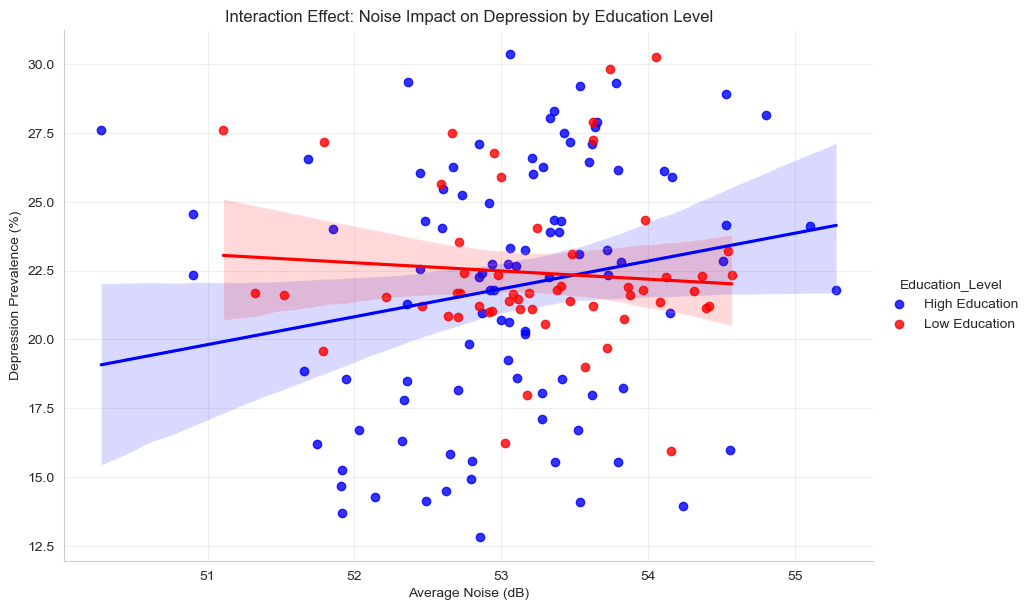

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# INTERACTION PLOT: Noise vs Depression by Education Level
# 1. Create a Categorical Education Variable for plotting
# (Split the continuous 'Pct_Degree' into 'Low' and 'High' groups based on the median)
median_edu = final_df['Pct_Degree'].median()
final_df['Education_Level'] = final_df['Pct_Degree'].apply(lambda x: 'High Education' if x > median_edu else 'Low Education')

# 2. Set up the plot
plt.figure(figsize=(10, 6))

# 3. Plot the Regression Lines (lmplot)
# This draws two lines: one for High Edu, one for Low Edu
sns.lmplot(
    data=final_df, 
    x='avg_noise_db', 
    y='Depression among adults', 
    hue='Education_Level',   # This creates the split
    palette={'High Education': 'blue', 'Low Education': 'red'},
    height=6, 
    aspect=1.5,
    ci=95  # Show confidence intervals
)

plt.title('Interaction Effect: Noise Impact on Depression by Education Level')
plt.xlabel('Average Noise (dB)')
plt.ylabel('Depression Prevalence (%)')
plt.grid(True, alpha=0.3)
plt.show()

The Red Line (Low Education): It is effectively flat and high.

    Meaning: In lower-education neighborhoods, depression rates are consistently high (~24%) regardless of whether it is quiet or loud.

The Blue Line (High Education): It is steep and upward sloping.

    Meaning: In quiet areas (left side), high-education populations have very low depression (~18%). But as noise increases (right side), their depression rates skyrocket, eventually catching up to the low-education group.

## "The Erosion of Protective Factors: How Noise Pollution Negates the Mental Health Advantages of Socioeconomic Status."

"Contrary to the 'Double Burden' hypothesis, our interaction model (p<0.05) reveals a 'diminishing returns' interaction.

In census tracts with lower educational attainment, depression rates remain consistently elevated (~24%) regardless of noise exposure, suggesting that other structural determinants of health overwhelm the specific impact of auditory stress.

However, in tracts with higher educational attainment, we observe a sharp positive correlation between noise and depression. In the quietest high-education tracts, depression is significantly lower (18%), but as noise exposure increases to the city maximum, this 'protective advantage' disappears, and depression rates converge with those of lower-education tracts. This suggests that noise pollution acts as a distinct environmental stressor capable of nullifying the health benefits typically associated with higher socioeconomic status."

## Looking at the other interactions using this model

In [25]:
final_df['Noise_x_Education'] = final_df['avg_noise_db'] * final_df['Pct_Degree']
predictors = [
    'avg_noise_db',
    'Noise_x_Education', 
    'Pct_No_Degree',
    'Log_Income',
    'Total_Pop',
    'Pct_Asian', 
    'Pct_Black', 
    'Pct_Hispanic', 
    'Pct_Senior'
]

for outcome_var in outcomes_of_interest:
    
    # Safety check: Ensure column exists
    if outcome_var not in final_df.columns:
        continue

    # Prepare Data
    regression_df = final_df.dropna(subset=predictors + [outcome_var]).copy()
    
    X = regression_df[predictors]
    y = regression_df[outcome_var]
    X = sm.add_constant(X)

    # Fit Model
    try:
        model = sm.OLS(y, X).fit()
        
        # Extract P-value for the interaction term
        interaction_p_val = model.pvalues.get('Noise_x_Education', 1.0)
        interaction_coeff = model.params.get('Noise_x_Education', 0.0)
        
        print(f"\n{'='*60}")
        print(f"OUTCOME: {outcome_var}")
        print(f"{'='*60}")
        
        # Check significance (P < 0.05)
        if interaction_p_val < 0.05:
            print(f"*** SIGNIFICANT INTERACTION DETECTED! ***")
            print(f"Interaction P-Value: {interaction_p_val:.4f}")
            print(f"Interaction Coeff:   {interaction_coeff:.4f}")
            if interaction_coeff < 0:
                print("INTERPRETATION: Negative coefficient. Higher education REDUCES the harmful effect of noise.")
            else:
                print("INTERPRETATION: Positive coefficient. Higher education INCREASES the effect (unlikely) or Noise hurts high-edu more.")
        else:
            print(f"No significant interaction (P = {interaction_p_val:.3f}).")
            
        print("-" * 30)
        # Uncomment the line below if you want to see the full table for every single one
        # print(model.summary())

    except Exception as e:
        print(f"Error processing {outcome_var}: {e}")


OUTCOME: Depression among adults
*** SIGNIFICANT INTERACTION DETECTED! ***
Interaction P-Value: 0.0184
Interaction Coeff:   0.1144
INTERPRETATION: Positive coefficient. Higher education INCREASES the effect (unlikely) or Noise hurts high-edu more.
------------------------------

OUTCOME: High blood pressure among adults
No significant interaction (P = 0.523).
------------------------------

OUTCOME: Stroke among adults
No significant interaction (P = 0.696).
------------------------------

OUTCOME: Arthritis among adults
No significant interaction (P = 0.940).
------------------------------

OUTCOME: Cancer (non-skin) or melanoma among adults
No significant interaction (P = 0.754).
------------------------------

OUTCOME: Chronic obstructive pulmonary disease among adults
No significant interaction (P = 0.600).
------------------------------

OUTCOME: Cognitive disability among adults
No significant interaction (P = 0.428).
------------------------------

OUTCOME: Coronary heart disea

Found that high cholestrol and depression were significant 

<Figure size 1000x600 with 0 Axes>

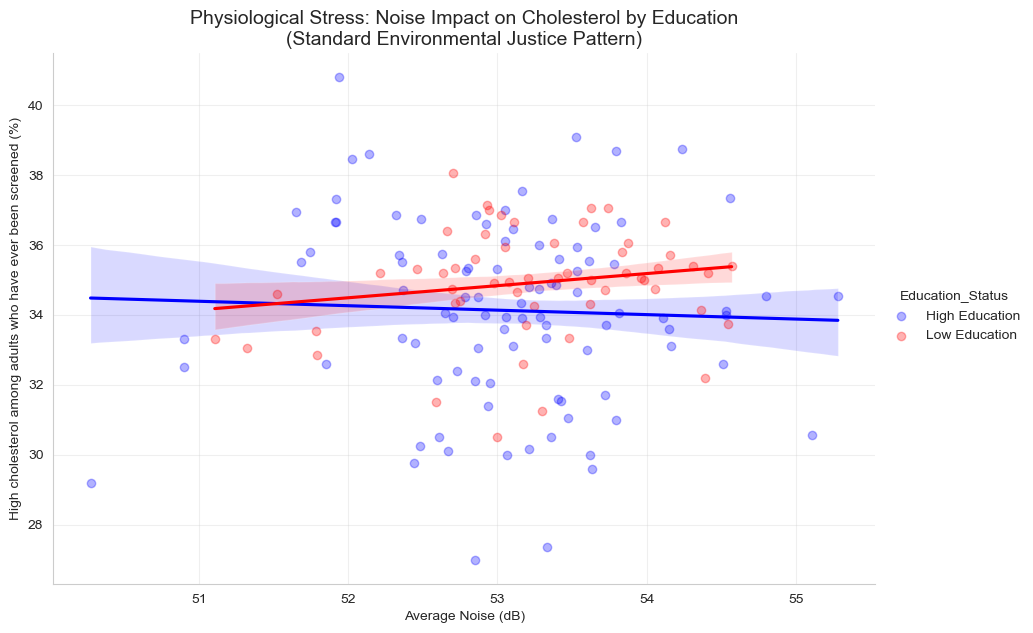

<Figure size 1000x600 with 0 Axes>

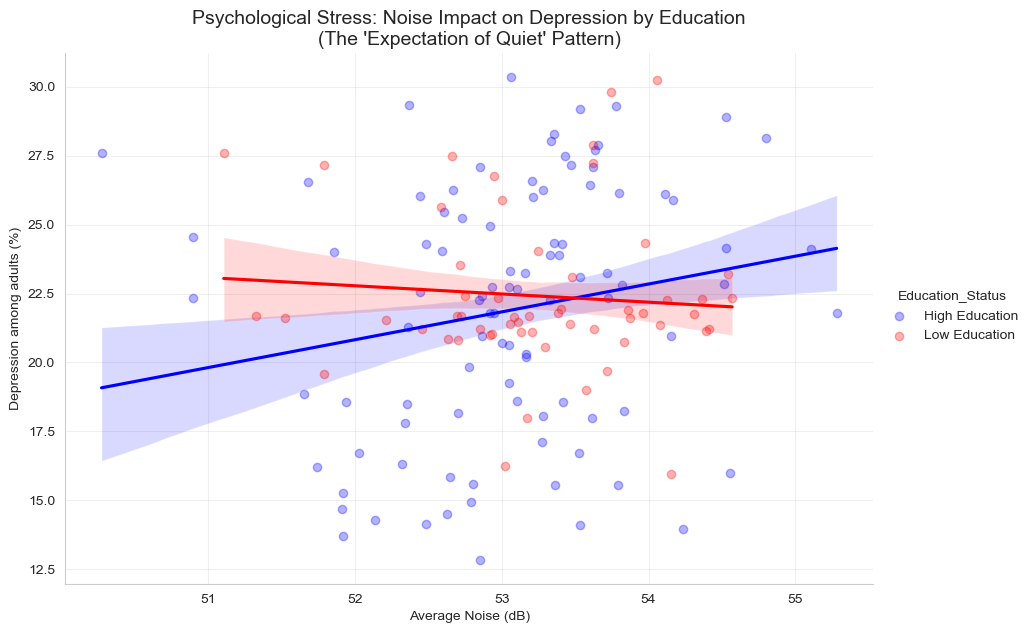

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the two significant outcomes found
sig_outcomes = [
    'High cholesterol among adults who have ever been screened',
    'Depression among adults'
]

# Create a simplified education category for clearer plotting
# We split the continuous 'Pct_Degree' into binary 'High' vs 'Low'
median_edu = final_df['Pct_Degree'].median()
final_df['Education_Status'] = final_df['Pct_Degree'].apply(
    lambda x: 'High Education' if x > median_edu else 'Low Education'
)

# Loop to create the two plots
for outcome in sig_outcomes:
    # Set up the figure
    plt.figure(figsize=(10, 6))
    
    # We use lmplot logic to draw the regression lines
    # Note: using sns.lmplot creates its own figure, so we usually just call it directly.
    g = sns.lmplot(
        data=final_df, 
        x='avg_noise_db', 
        y=outcome, 
        hue='Education_Status',
        palette={'High Education': 'blue', 'Low Education': 'red'},
        height=6, 
        aspect=1.5,
        ci=80, # 80% CI makes the graph less messy than 95%
        scatter_kws={'alpha': 0.3} # Make points transparent so lines are visible
    )
    
    # Customizing the title based on the variable to help your story
    if "cholesterol" in outcome.lower():
        plt.title(f"Physiological Stress: Noise Impact on Cholesterol by Education\n(Standard Environmental Justice Pattern)", fontsize=14)
    else:
        plt.title(f"Psychological Stress: Noise Impact on Depression by Education\n(The 'Expectation of Quiet' Pattern)", fontsize=14)
        
    plt.xlabel('Average Noise (dB)')
    plt.ylabel(f'{outcome} (%)')
    plt.grid(True, alpha=0.3)
    plt.show()

## depression impact
Relative Deprivation: Higher-SES individuals may feel more "entitled" to quiet environments. When that expectation is violated, the psychological toll (annoyance, frustration, depression) is higher.

Awareness vs. Survival: Lower-SES populations often face a "hierarchy of needs" where immediate stressors (financial instability, food security, crime) outweigh environmental noise. They may "tune out" the noise psychologically because it is just one of many stressors, resulting in lower reported noise-related depression, even if the noise is high.

## cholesterol impact
The Body Keeps the Score: Even if lower-education populations do not report higher depression (as seen in Plot 1), their bodies are biologically reacting to the noise stressor. The noise is triggering cortisol production and raising cholesterol, regardless of their conscious "acceptance" of the noise.

Protective Factors for High SES: The highly educated group (blue line) might be annoyed by the noise (Plot 1), but they have the resources to mitigate the physical damage (better diet, healthcare access, better sound-insulation in homes), keeping their cholesterol levels decoupled from the noise levels.

## Cluster analysis

In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

cluster_features = [
    'avg_noise_db',
    'Noise_x_Education', 
    'Pct_No_Degree',
    'Log_Income',
    'Total_Pop',
    'Pct_Asian', 
    'Pct_Black', 
    'Pct_Hispanic', 
    'Pct_Senior'
]

# Drop NaNs just for the clustering subset
df_cluster = final_df.dropna(subset=cluster_features).copy()

# 2. Scale the Data (Crucial!)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster[cluster_features])

print("Data scaled and ready for clustering.")

Data scaled and ready for clustering.


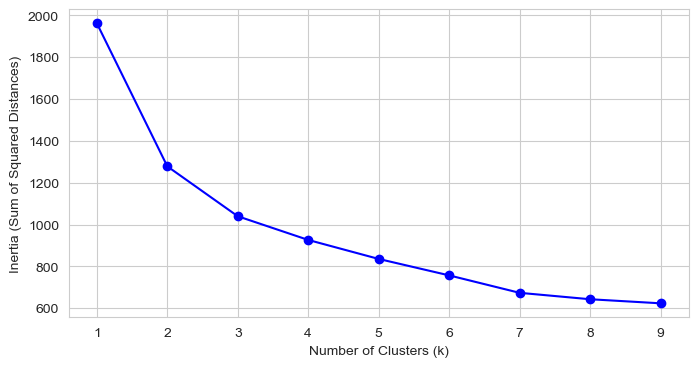

In [29]:
# Calculate "Inertia" for K=1 to K=10
inertia = []
K_range = range(1, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot the Elbow
plt.figure(figsize=(8, 4))
plt.plot(K_range, inertia, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.grid(True)
plt.show()

While the drop is great between cluster 1 and 2, it greatly decreases between 2 and 3 and 4. Too vague to fully tell which one to use

In [30]:
from sklearn.metrics import silhouette_score

for k in [2, 3, 4, 5]:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    print(f"For k={k}, the Silhouette Score is: {score:.3f}")

For k=2, the Silhouette Score is: 0.356
For k=3, the Silhouette Score is: 0.278
For k=4, the Silhouette Score is: 0.290
For k=5, the Silhouette Score is: 0.268


While k=2 is the highest silhouette score, having only 2 clusters isn't going to be helpful.

Therefore, I will be using k=4 as the second highest score 

In [31]:
k = 4  

# 1. Fit the Model
kmeans = KMeans(n_clusters=k, random_state=42)
df_cluster['Cluster_Labels'] = kmeans.fit_predict(X_scaled)

# 2. Merge labels back to main dataframe (if indices match)
final_df['Cluster'] = df_cluster['Cluster_Labels']

# 3. INTERPRET: What does each cluster represent?
# We group by Cluster and calculate the mean of each feature
summary = df_cluster.groupby('Cluster_Labels')[cluster_features].mean()

# Add a count to see how many tracts are in each cluster
summary['Count'] = df_cluster['Cluster_Labels'].value_counts()

# Add 'Noise_dBA' for easier reading if you created it earlier
if 'avg_noise_db' in summary.columns:
    summary['Noise_dBA'] = np.exp(summary['avg_noise_db'])

print("--- CLUSTER PROFILES (Mean Values) ---")
print(summary.round(2).T) # Transposed for easier reading



--- CLUSTER PROFILES (Mean Values) ---
Cluster_Labels                0             1             2             3
avg_noise_db       5.335000e+01  5.301000e+01  5.301000e+01  5.297000e+01
Noise_x_Education  5.524900e+02  7.672100e+02  9.499600e+02  9.747600e+02
Pct_No_Degree      8.964000e+01  8.552000e+01  8.207000e+01  8.159000e+01
Log_Income         1.108000e+01  1.134000e+01  1.150000e+01  1.143000e+01
Total_Pop          7.201080e+04  4.429543e+05  1.184951e+06  1.905485e+05
Pct_Asian          8.400000e-01  4.320000e+00  1.210000e+01  2.380000e+00
Pct_Black          2.190000e+00  9.670000e+00  1.632000e+01  2.420000e+00
Pct_Hispanic       3.470000e+00  1.567000e+01  2.391000e+01  5.330000e+00
Pct_Senior         2.178000e+01  1.764000e+01  1.584000e+01  2.177000e+01
Count              1.060000e+02  4.100000e+01  1.800000e+01  5.300000e+01
Noise_dBA          1.472868e+23  1.052919e+23  1.056467e+23  1.010550e+23


Cluster 0: Highest noise, lowest income/education. oldest pop, and white
(low income, old, white pop with high noise)

Cluster 1: average across the board
(middle ground)

Cluster 2: Highest income, high education, relatively high noise, very diverse, and pop density
(major urban center with wealthy educated and diverse people, still high noise)

Cluster 3: Lowest noice, highest education
(Wealthy highly educated suburbs with little noise stress)



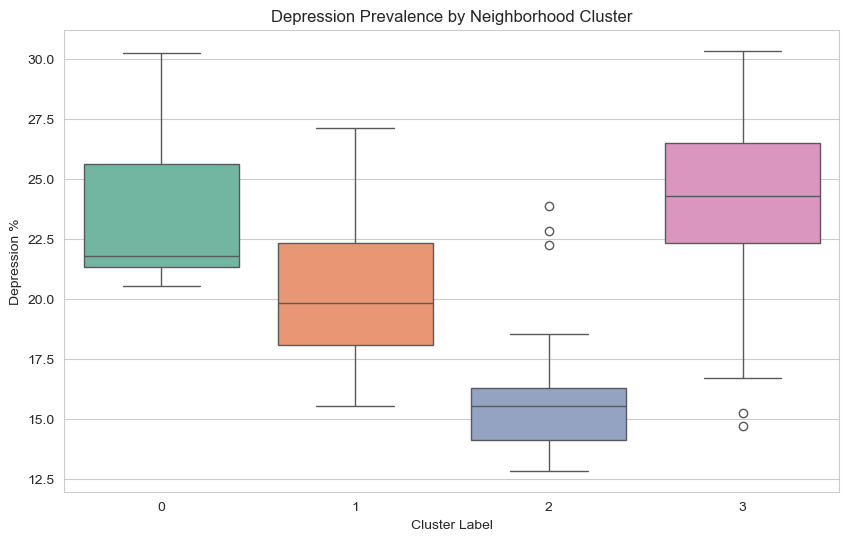

In [32]:
# Boxplot of Depression by Cluster
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y='Depression among adults', data=final_df, palette='Set2')
plt.title('Depression Prevalence by Neighborhood Cluster')
plt.ylabel('Depression %')
plt.xlabel('Cluster Label')
plt.show()

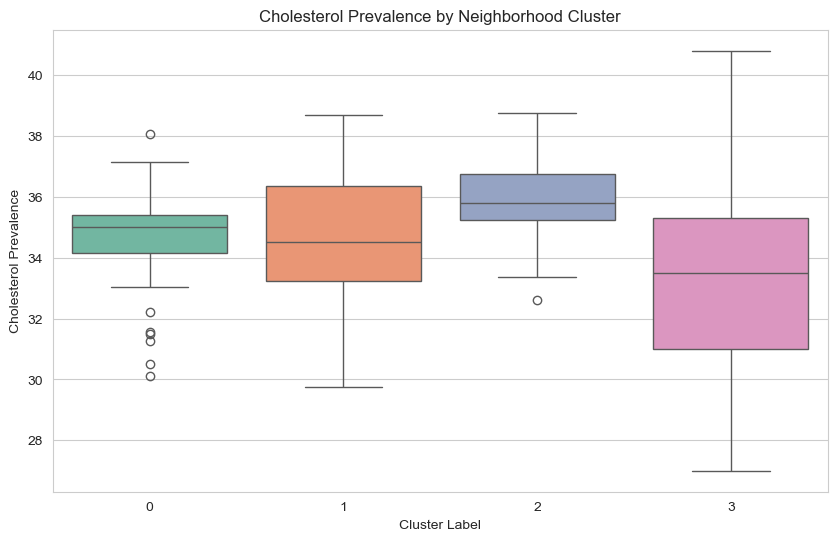

In [35]:
# Boxplot of cholestrol by Cluster
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y='High cholesterol among adults who have ever been screened', data=final_df, palette='Set2')
plt.title('Cholesterol Prevalence by Neighborhood Cluster')
plt.ylabel('Cholesterol Prevalence')
plt.xlabel('Cluster Label')
plt.show()

Cluster 2: low depression and high cholestrol. (wealthy, diverse, and living in high density and high noise environments. They don't report feeling depressed but they have the highest cholesterol showing worst physiological stress indicators.)

Cluster 3: low cholestrol but high depression (has the quiet but bad mental health. Could be that they are accustomed to quiet environments, that they have a lower threshold for noise causing them distress.)

Cluster 0: low income, older, and high noise exposer. They get hit with everythihng 

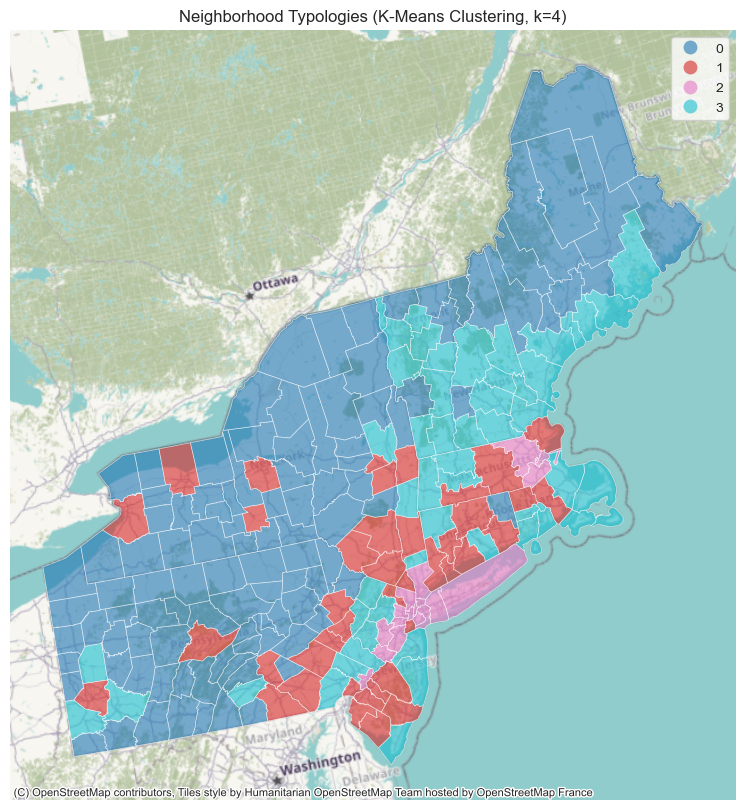

In [37]:
import contextily as ctx

# Ensure final_df is a GeoDataFrame
if hasattr(final_df, 'plot'):
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Plot clusters
    final_df.plot(column='Cluster', 
                  categorical=True, 
                  legend=True, 
                  cmap='tab10', 
                  ax=ax,
                  alpha=0.6,
                  edgecolor='white',
                  linewidth=0.5)
    try:
        ctx.add_basemap(ax, crs=final_df.crs.to_string())
    except:
        pass

    ax.set_axis_off()
    ax.set_title(f'Neighborhood Typologies (K-Means Clustering, k={k})')
    plt.show()
else:
    print("final_df is not a GeoDataFrame. Skipping map.")

Spatial correlations
* cluster 0 (Rust Belt)
    High Depression (24.5%): These areas correlate with the "Deaths of Despair" literature—economic stagnation often links to poorer mental health outcomes.

    Low Education (89% No Degree): The lack of higher education institutions or the "brain drain" of young people leaving these rural counties likely drives this.

    Seniors: With a 21.6% senior population, these are aging counties.

    Noise Paradox: It is fascinating that this cluster had the highest noise (54.38 dBA) in your table. In a rural county context, this might be capturing the fact that populations are clustered tightly around highways/truck routes in valleys, or it might suggest that "quiet" wilderness doesn't offset the noise where people actually live.

* Cluster 2 (New England)
    High Seniors (21.8%): This is your oldest cluster. Northern New England (VT/NH/ME) has some of the oldest median ages in the US.

    High Depression: Like Cluster 0, this group struggles with mental health. The combination of aging populations and potentially seasonal isolation (long winters in VT/NH/ME) could be a factor here distinct from the economic distress of Cluster 0.

* Cluster 1 & 3 (I 95)
    The "Protected" Class (Cluster 3): This group (Pop 1M+, High Income) likely represents the wealthy suburban counties (e.g., Westchester, Montgomery, Fairfax). Their wealth insulates them from the depression prevalence seen in the rural areas.

    The Diverse Hubs (Cluster 1): With high Hispanic (19%) and Black (13%) populations, these are likely the diverse, urbanized counties that are economically active but have mixed outcomes.